In [1]:
import pandas as pd
import sys
import os
import re

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [2]:
module_path = os.path.abspath(os.path.join('..'))    

if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from src.db.session import engine

query = "SELECT * FROM ads"

df = pd.read_sql(query, con=engine)

In [4]:
display(df.head())

,avito_id,url,title,price,description,location,published_at,condition,seller_name,seller_rating,seller_reviews_count
0,7618498005,https://www.avito.ru/moskva/telefony/iphone_13...,"iPhone 13, 512 ГБ",35000,IPhone 13 512Gb Red.\n\nОфициальный интернет-м...,Москве,2025-09-11 03:30:37.812939+00:00,Новый,Wonderland,5.0,29.0
1,7618920549,https://www.avito.ru/moskva/telefony/iphone_13...,"iPhone 13, 512 ГБ",35000,IPhone 13 512Гб тёмная ночь.\n\nОфициальный ин...,Москве,2025-09-11 03:30:37.823598+00:00,Новый,Wonderland,5.0,29.0
2,7643087653,https://www.avito.ru/moskva/telefony/iphone_13...,"iPhone 13, 512 ГБ",35500,IPhone 13 512Gb.\nРады приветствовать вас в оф...,Москве,2025-09-11 03:30:37.831996+00:00,Новый,TechnoPhone,5.0,28.0
3,7604318089,https://www.avito.ru/moskva/telefony/iphone_13...,"iPhone 13, 512 ГБ",36000,Добро пожаловать в интернет-магазин — applex.\...,Москве,2025-09-11 03:30:37.840493+00:00,Новый,AppleX,4.9,115.0
4,7604622402,https://www.avito.ru/moskva/telefony/iphone_13...,"iPhone 13, 128 ГБ",32300,Добро пожаловать в интернет-магазин — applex.\...,Москве,2025-09-11 03:30:37.848437+00:00,Новый,AppleX,4.9,115.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2940 entries, 0 to 2939
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   avito_id              2940 non-null   int64              
 1   url                   2940 non-null   object             
 2   title                 2940 non-null   object             
 3   price                 2940 non-null   int64              
 4   description           2906 non-null   object             
 5   location              2940 non-null   object             
 6   published_at          2940 non-null   datetime64[ns, UTC]
 7   condition             2908 non-null   object             
 8   seller_name           2224 non-null   object             
 9   seller_rating         2144 non-null   float64            
 10  seller_reviews_count  2144 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(2), int64(2), object(6)
memory usa

In [6]:
display(df['price'].describe())

count      2940.000000
mean      37462.138095
std       62358.532114
min         100.000000
25%       28000.000000
50%       32000.000000
75%       37500.000000
max      999999.000000
Name: price, dtype: float64

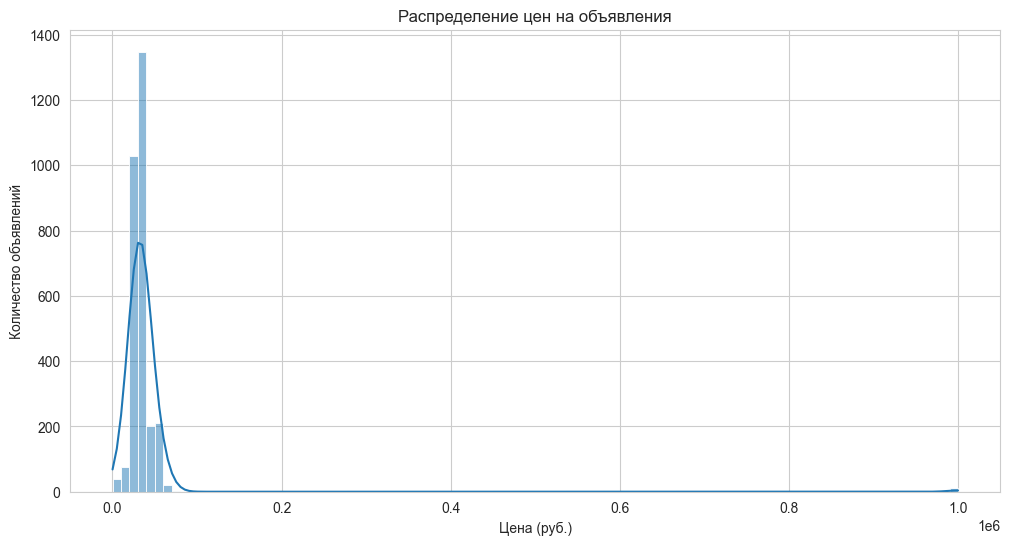

In [7]:
plt.figure(figsize=(12, 6))
sns.histplot(df['price'], bins=100, kde=True)
plt.title("Распределение цен на объявления")
plt.xlabel("Цена (руб.)")
plt.ylabel("Количество объявлений")
plt.show()

Отбрасываем цены ниже 2067 руб. и выше 61830 руб.
Размер исходного датафрейма: 2940
Размер отфильтрованного датафрейма: 2880


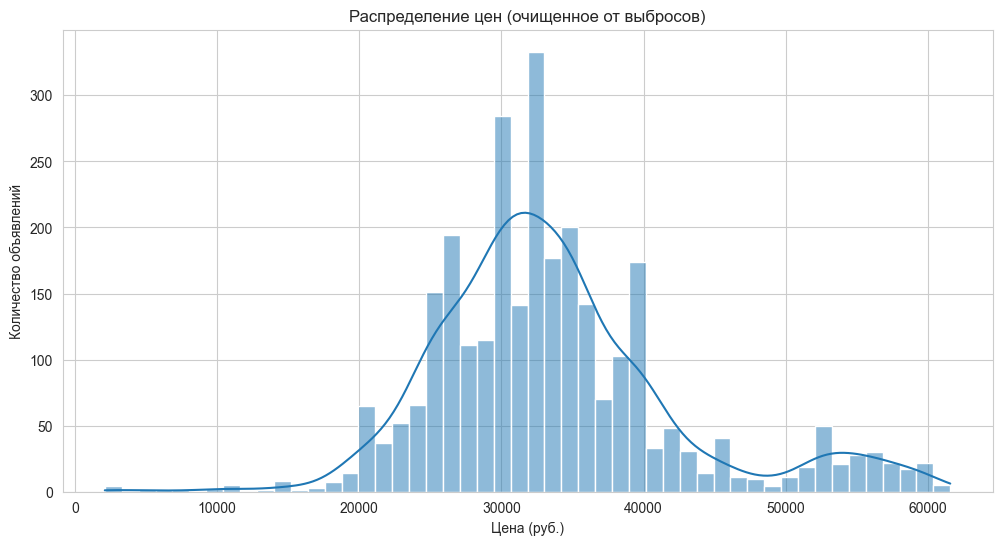

In [8]:
min_threshold = df['price'].quantile(0.01)
max_threshold = df['price'].quantile(0.99)

print(f"Отбрасываем цены ниже {min_threshold:.0f} руб. и выше {max_threshold:.0f} руб.")

df_filtered = df[(df['price'] > min_threshold) & (df['price'] < max_threshold)]

print(f"Размер исходного датафрейма: {len(df)}")
print(f"Размер отфильтрованного датафрейма: {len(df_filtered)}")

plt.figure(figsize=(12, 6))
sns.histplot(df_filtered['price'], bins=50, kde=True)
plt.title("Распределение цен (очищенное от выбросов)")
plt.xlabel("Цена (руб.)")
plt.ylabel("Количество объявлений")
plt.show()

In [9]:
display(df_filtered['price'].describe())

count     2880.000000
mean     33657.540278
std       8647.794869
min       2094.000000
25%      28000.000000
50%      32000.000000
75%      37000.000000
max      61580.000000
Name: price, dtype: float64

In [10]:
print("Количество объявлений по состоянию:")
display(df_filtered['condition'].value_counts())

Количество объявлений по состоянию:


condition
Новый    1610
Б/у      1267
Name: count, dtype: int64

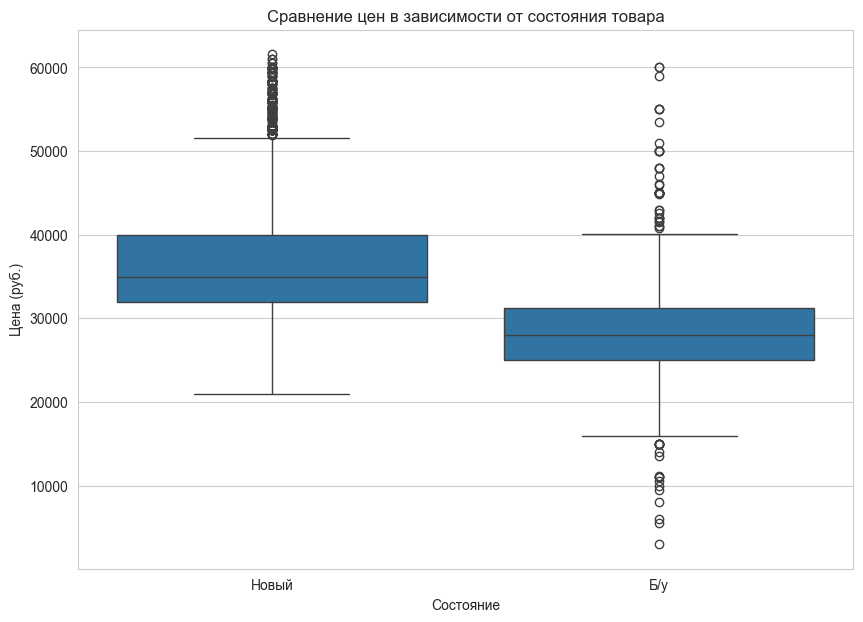

In [11]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='condition', y='price', data=df_filtered)
plt.title("Сравнение цен в зависимости от состояния товара")
plt.xlabel("Состояние")
plt.ylabel("Цена (руб.)")
plt.show()

Анализируем 2114 объявлений с информацией о продавце.


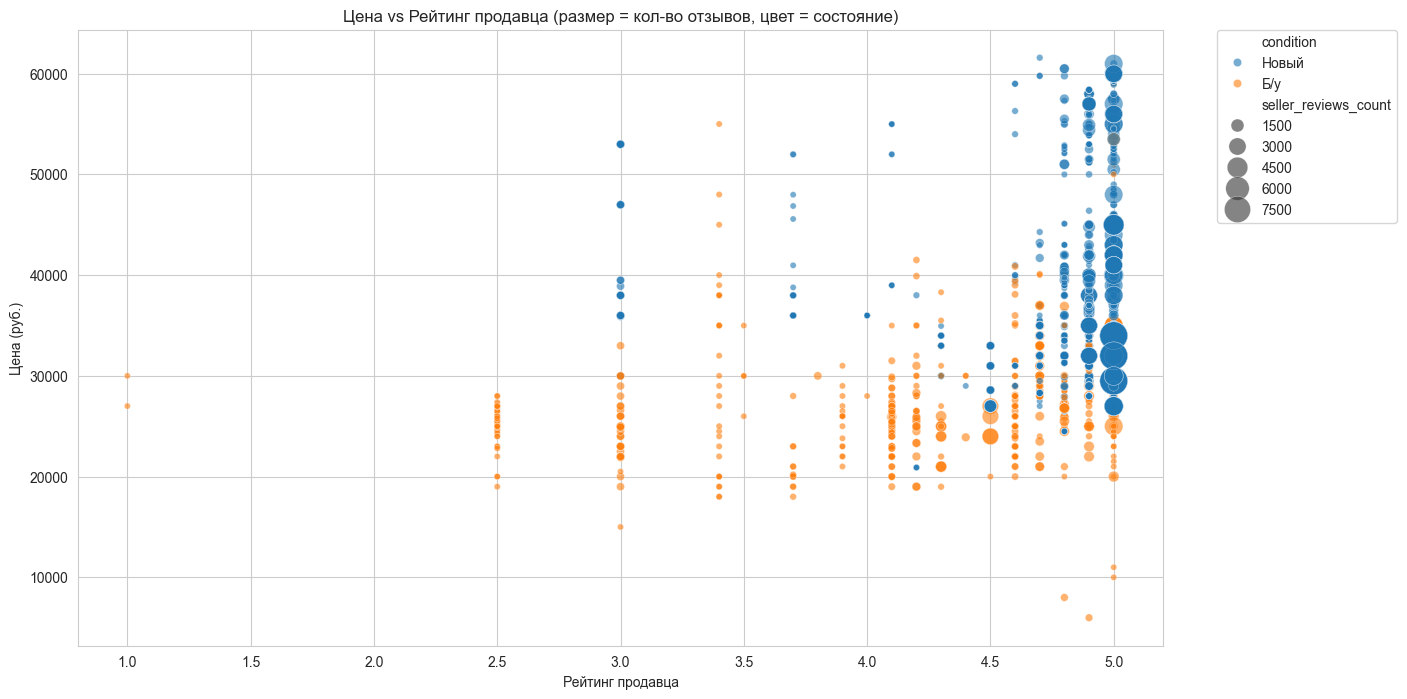

In [12]:
df_with_sellers = df_filtered[df_filtered['seller_reviews_count'] > 0].copy()
print(f"Анализируем {len(df_with_sellers)} объявлений с информацией о продавце.")

plt.figure(figsize=(14, 8))
sns.scatterplot(
    x='seller_rating',
    y='price',                                      
    hue='condition',                                                                           
    size='seller_reviews_count',
    sizes=(20, 400),
    alpha=0.6,
    data=df_with_sellers
)
plt.title("Цена vs Рейтинг продавца (размер = кол-во отзывов, цвет = состояние)")
plt.xlabel("Рейтинг продавца")
plt.ylabel("Цена (руб.)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

Количество объявлений по объему памяти:


C:\Users\k1ree8\AppData\Local\Temp\ipykernel_15400\370594333.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['memory_gb'] = df_filtered['title'].apply(extract_memory)


memory_gb
128.0    1542
256.0     822
512.0     389
Name: count, dtype: int64

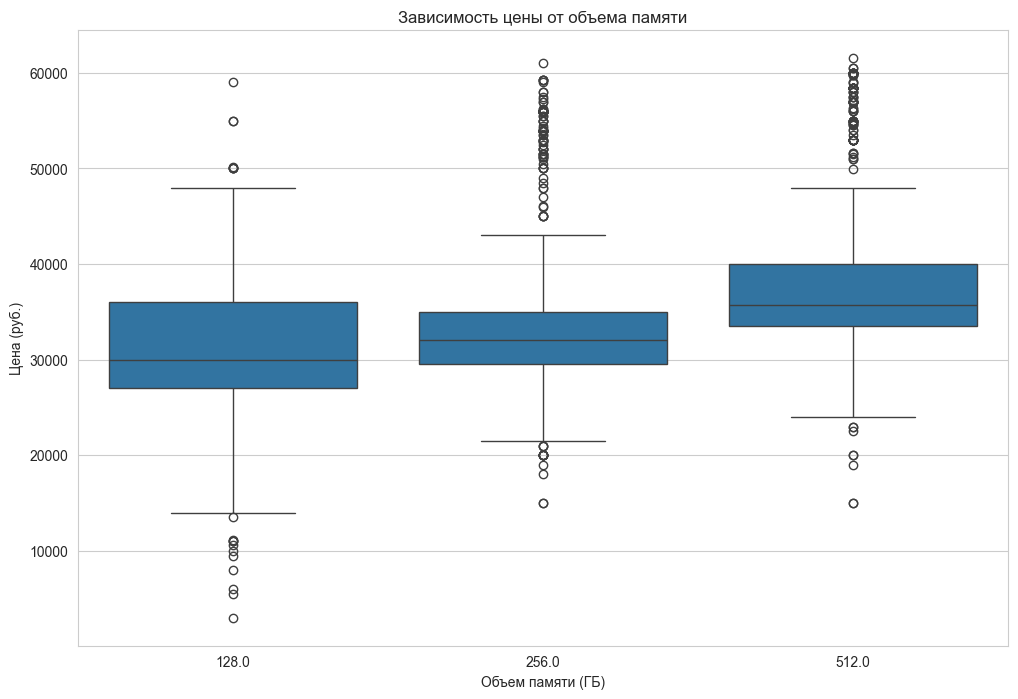

In [13]:
def extract_memory(title):
    match = re.search(r'(\d+)\s*гб', title, re.IGNORECASE)
    if match:
        return int(match.group(1))
    return None

df_filtered['memory_gb'] = df_filtered['title'].apply(extract_memory)

print("Количество объявлений по объему памяти:")
display(df_filtered['memory_gb'].value_counts())

plt.figure(figsize=(12, 8))
sns.boxplot(x='memory_gb', y='price', data=df_filtered)
plt.title("Зависимость цены от объема памяти")
plt.xlabel("Объем памяти (ГБ)")
plt.ylabel("Цена (руб.)")
plt.show()

In [14]:
features_to_use = [
    'price',
    'condition',
    'seller_rating',
    'seller_reviews_count',
    'memory_gb'
]

df_model = df_filtered[features_to_use].copy()

df_model.dropna(inplace=True)

print(f"Размер датафрейма после удаления пропусков: {len(df_model)}")

df_model = pd.get_dummies(df_model, columns=['condition', 'memory_gb'], drop_first=True)

X = df_model.drop('price', axis=1)
y = df_model['price']

print("Матрица признаков X (первые 5 строк):")
display(X.head())

print("Целевая переменная y (первые 5 строк):")
display(y.head())

X.info()

Размер датафрейма после удаления пропусков: 2004
Матрица признаков X (первые 5 строк):


,seller_rating,seller_reviews_count,condition_Новый,memory_gb_256.0,memory_gb_512.0
0,5.0,29.0,True,False,True
1,5.0,29.0,True,False,True
2,5.0,28.0,True,False,True
3,4.9,115.0,True,False,True
4,4.9,115.0,True,False,False


Целевая переменная y (первые 5 строк):


0    35000
1    35000
2    35500
3    36000
4    32300
Name: price, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Index: 2004 entries, 0 to 2939
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   seller_rating         2004 non-null   float64
 1   seller_reviews_count  2004 non-null   float64
 2   condition_Новый       2004 non-null   bool   
 3   memory_gb_256.0       2004 non-null   bool   
 4   memory_gb_512.0       2004 non-null   bool   
dtypes: bool(3), float64(2)
memory usage: 52.8 KB


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Размер обучающей выборки: {X_train.shape[0]} записей")
print(f"Размер тестовой выборки: {X_test.shape[0]} записей")

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)

print(f"Средняя абсолютная ошибка (MAE) на тестовой выборке: {mae:.2f} руб.")

Размер обучающей выборки: 1603 записей
Размер тестовой выборки: 401 записей
Средняя абсолютная ошибка (MAE) на тестовой выборке: 5242.26 руб.


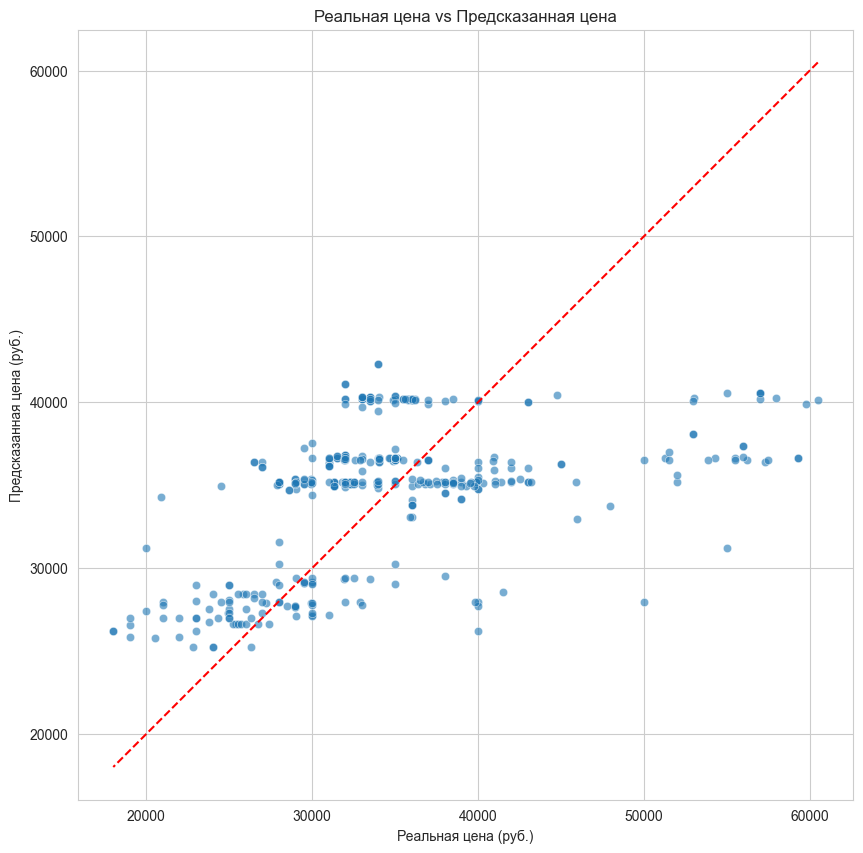

In [16]:
results_df = pd.DataFrame({'Реальная цена': y_test, 'Предсказанная цена': y_pred})

plt.figure(figsize=(10, 10))
sns.scatterplot(x='Реальная цена', y='Предсказанная цена', data=results_df, alpha=0.6)

p1 = max(max(y_test), max(y_pred))
p2 = min(min(y_test), min(y_pred))
plt.plot([p1, p2], [p1, p2], 'r--')

plt.title("Реальная цена vs Предсказанная цена")
plt.xlabel("Реальная цена (руб.)")
plt.ylabel("Предсказанная цена (руб.)")
plt.axis('equal')
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)

print(f"Средняя квадратичная ошибка (MSE): {mse:.2f}")
print(f"Корень из средней квадратичной ошибки (RMSE): {rmse:.2f} руб.")
print(f"Напоминание: Средняя абсолютная ошибка (MAE): {mae:.2f} руб.")

print(f"\nРазница между RMSE и MAE: {rmse - mae:.2f} руб.")

Средняя квадратичная ошибка (MSE): 48058108.20
Корень из средней квадратичной ошибки (RMSE): 6932.40 руб.
Напоминание: Средняя абсолютная ошибка (MAE): 5242.26 руб.

Разница между RMSE и MAE: 1690.13 руб.


In [20]:
intercept = model.intercept_
print(f"Свободный член (intercept), β₀: {intercept:.2f} руб.")

coefficients = model.coef_

feature_weights = pd.Series(coefficients, index=X.columns)

print("\nВеса признаков (коэффициенты), β₁, β₂, ...:")
display(feature_weights.sort_values(ascending=False))

Свободный член (intercept), β₀: 22496.59 руб.

Веса признаков (коэффициенты), β₁, β₂, ...:


condition_Новый         7230.267953
memory_gb_512.0         5031.494908
memory_gb_256.0         1436.777322
seller_rating           1087.411358
seller_reviews_count       0.244814
dtype: float64

In [25]:
X_matrix = X.values.astype(float) 
ones = np.ones((X_matrix.shape[0], 1)) 
X_matrix_with_intercept = np.hstack((ones, X_matrix))

y_vector = y.values

print("Размер матрицы X с добавленным столбцом единиц:", X_matrix_with_intercept.shape)
# Реализация формулы Нормального уравнения: β* = (XᵀX)⁻¹XᵀY
# Xᵀ (транспонирование)
XT = X_matrix_with_intercept.T
# XᵀX (матричное умножение)
XTX = XT @ X_matrix_with_intercept
# (XᵀX)⁻¹ (обращение матрицы)
XTX_inv = np.linalg.inv(XTX)
# XᵀY (матричное умножение)
XTY = XT @ y_vector
# Финальное умножение (XᵀX)⁻¹ @ (XᵀY)
beta_manual = XTX_inv @ XTY

print("\n--- Результаты, полученные 'вручную' ---")
print(f"Свободный член (β₀): {beta_manual[0]:.2f} руб.")
manual_weights = pd.Series(beta_manual[1:], index=X.columns)
print("Веса признаков:")
display(manual_weights.sort_values(ascending=False))


print("\n--- Результаты из scikit-learn (для сравнения) ---")
print(f"Свободный член (β₀): {model.intercept_:.2f} руб.")
print("Веса признаков:")
display(feature_weights.sort_values(ascending=False))

Размер матрицы X с добавленным столбцом единиц: (2004, 6)

--- Результаты, полученные 'вручную' ---
Свободный член (β₀): 22562.39 руб.
Веса признаков:


condition_Новый         7199.911916
memory_gb_512.0         4924.116309
memory_gb_256.0         1666.582944
seller_rating           1056.567401
seller_reviews_count       0.277725
dtype: float64


--- Результаты из scikit-learn (для сравнения) ---
Свободный член (β₀): 22496.59 руб.
Веса признаков:


condition_Новый         7230.267953
memory_gb_512.0         5031.494908
memory_gb_256.0         1436.777322
seller_rating           1087.411358
seller_reviews_count       0.244814
dtype: float64